In [20]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import warnings

from collections import OrderedDict
from scipy.special import expit as logistic

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
az.style.use('arviz-darkgrid')
az.rcParams["stats.credible_interval"] = 0.89


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

#### Code 12.1

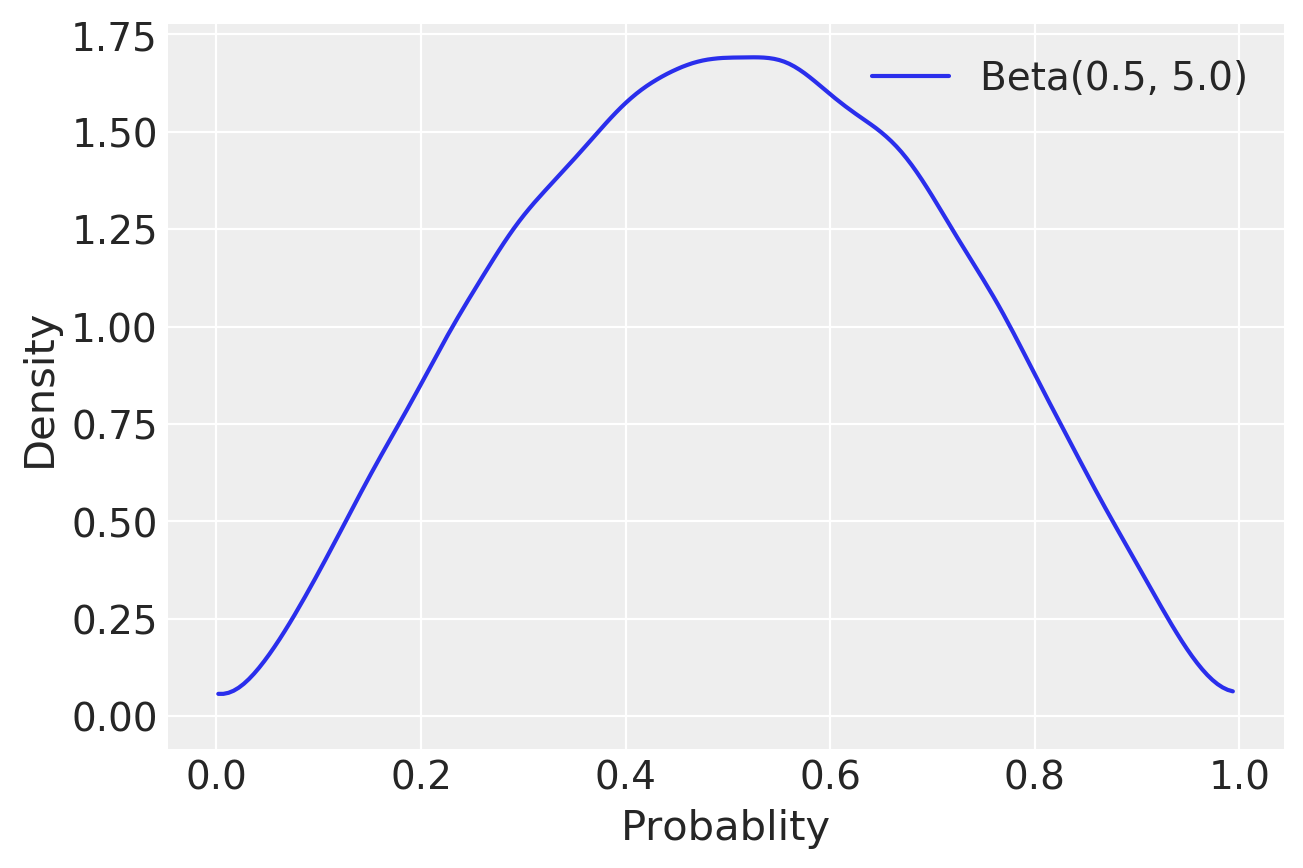

In [24]:
pbar = 0.5
theta = 5.
ax = az.plot_kde(
    pm.Beta.dist(pbar*theta, (1-pbar)*theta).random(size=100_000),
    label=f"Beta({pbar}, {theta})",
)
ax.set_xlabel("Probablity")
ax.set_ylabel("Density")
ax.set_title("");

#### Code 12.2

In [29]:
admit_df = pd.read_csv('Data/UCBadmit.csv', sep=';')
N = admit_df.applications.values
gid = (admit_df["applicant.gender"] == "female").astype(int).values
admit_df.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [30]:
with pm.Model() as m12_1:
    a = pm.Normal('a', 0., 1.5, shape=2)
    phi = pm.Exponential('phi', 1.)
    
    theta = pm.Deterministic('theta', phi + 2.)
    pbar = pm.Deterministic('pbar', pm.math.invlogit(a[gid]))
    
    A = pm.BetaBinomial(
        'A',
        pbar * theta, 
        (1. - pbar) * theta,
        N,
        observed=admit_df.admit.values
    )
    
    trace_12_1 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


#### Code 12.3

In [31]:
az.summary(trace_12_1, var_names=["a", "phi", "theta"], round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.46,0.41,-1.18,0.14,0.01,0.01,2720.52,2107.48,2731.31,2358.94,1.0
a[1],-0.33,0.42,-1.00,0.30,0.01,0.01,2928.68,2093.57,2949.06,2334.63,1.0
phi,1.03,0.79,0.00,2.03,0.02,0.01,2785.24,2785.24,1924.51,1206.59,1.0
theta,3.03,0.79,2.00,4.03,0.02,0.01,2785.24,2785.24,1924.51,1206.59,1.0


In [32]:
diff_a = trace_12_1["a"][:, 0] - trace_12_1["a"][:, 1]
az.summary({"diff_a": diff_a}, kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
diff_a,-0.13,0.59,-1.05,0.83


#### Code 12.4

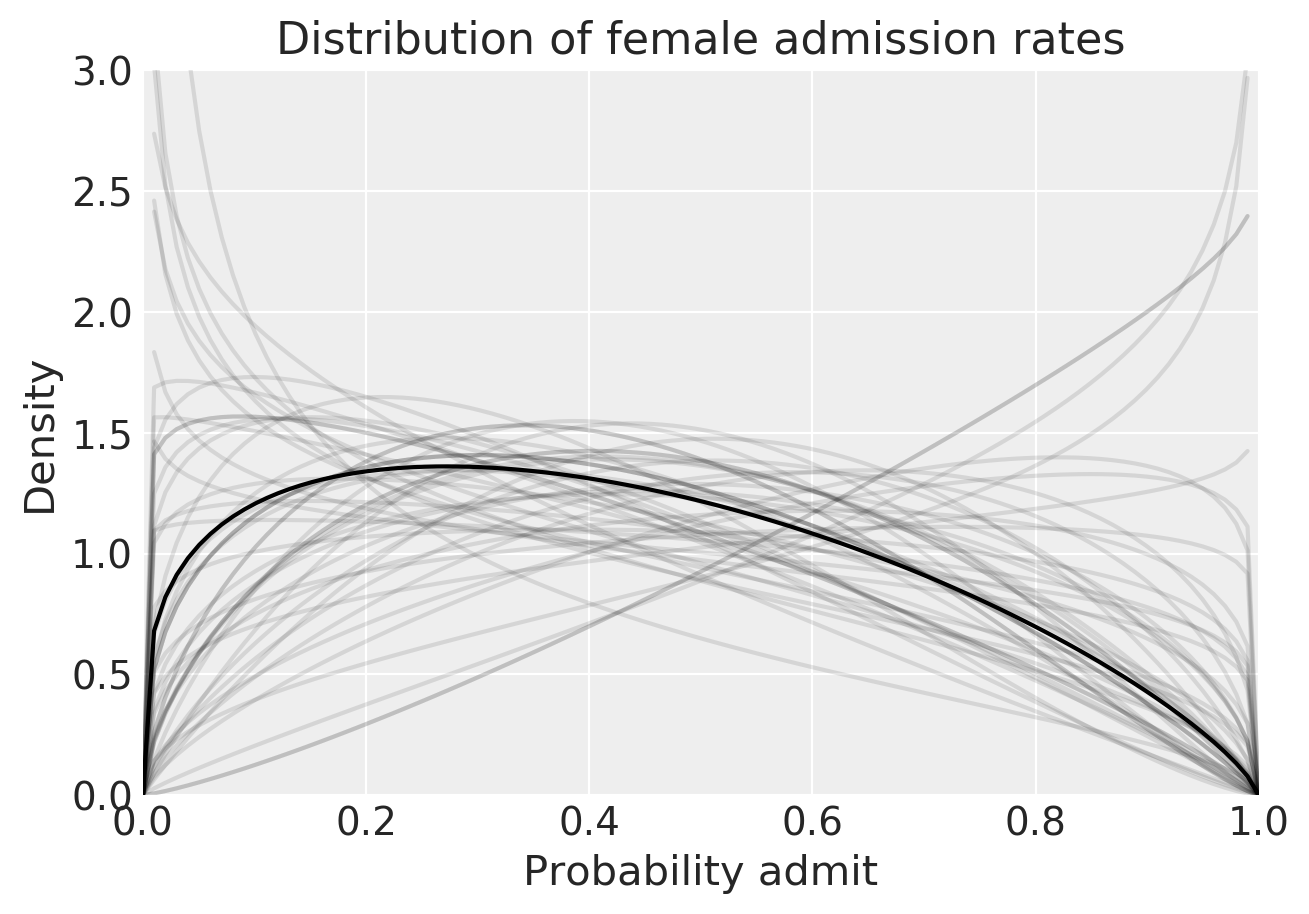

In [26]:
gid = 1
x_plot = np.linspace(0, 1, 100)

# draw posterior mean beta distribution:
pbar_mean = logistic(trace_12_1["a"][:, gid]).mean()
theta_mean = trace_12_1['theta'].mean()
plt.plot(
    x_plot,
    sp.stats.beta.pdf(x_plot, pbar_mean * theta_mean, (1. - pbar_mean) * theta_mean),
    c='k'
)

# draw 50 beta distributions sampled from posterior:
plt.plot(
    x_plot,
    sp.stats.beta.pdf(
        x_plot[:, np.newaxis],
        logistic(trace_12_1["a"][:, gid])[:50] * trace_12_1['theta'][:50],
        (1. - logistic(trace_12_1["a"][:, gid])[:50]) * trace_12_1['theta'][:50]
    ),
    c='k', alpha=0.1
)

plt.xlim(0., 1.)
plt.xlabel("Probability admit")
plt.ylim(0., 3.);
plt.ylabel("Density")
plt.title("Distribution of female admission rates");

#### Code 12.5

In [40]:
with m12_1:
    ppc = pm.sample_posterior_predictive(
        trace_12_1, random_seed=RANDOM_SEED
    )["A"]
pp_admit = ppc / N

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (12). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (12). Passed array should have shape (chains, draws, *shape)
  UserWarning,


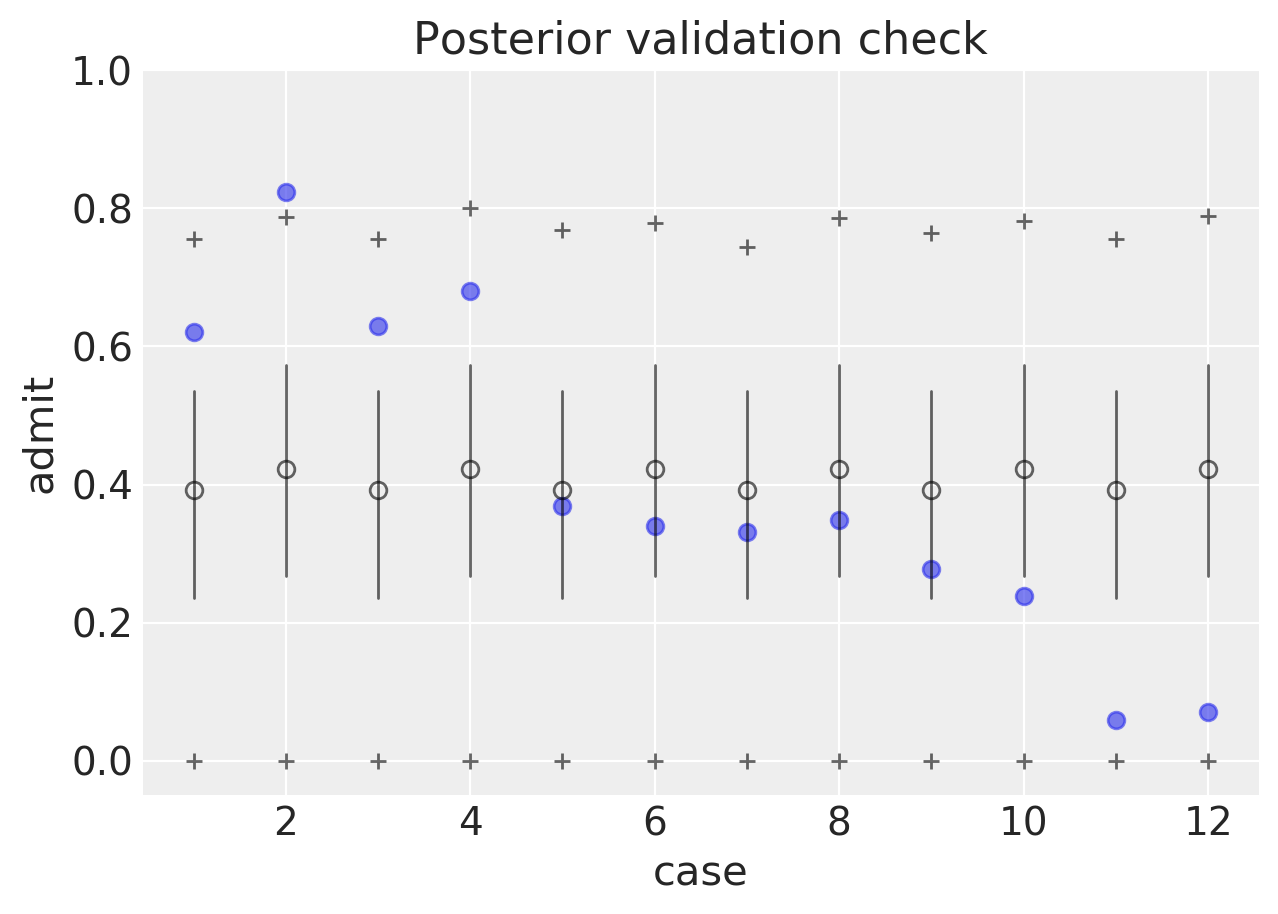

In [45]:
plt.plot(range(1, 13), admit_df.admit / N, "C0o", ms=6, alpha=0.6)
plt.plot(range(1, 13), trace_12_1["pbar"].mean(0), "ko", fillstyle="none", ms=6, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(trace_12_1["pbar"]).T, "k-", lw=1, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(pp_admit).T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(-0.05, 1);

#### Code 12.6

In [3]:
trolley_df = pd.read_csv('Data/Trolley.csv', sep=';')
trolley_df.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


#### Code 11.2

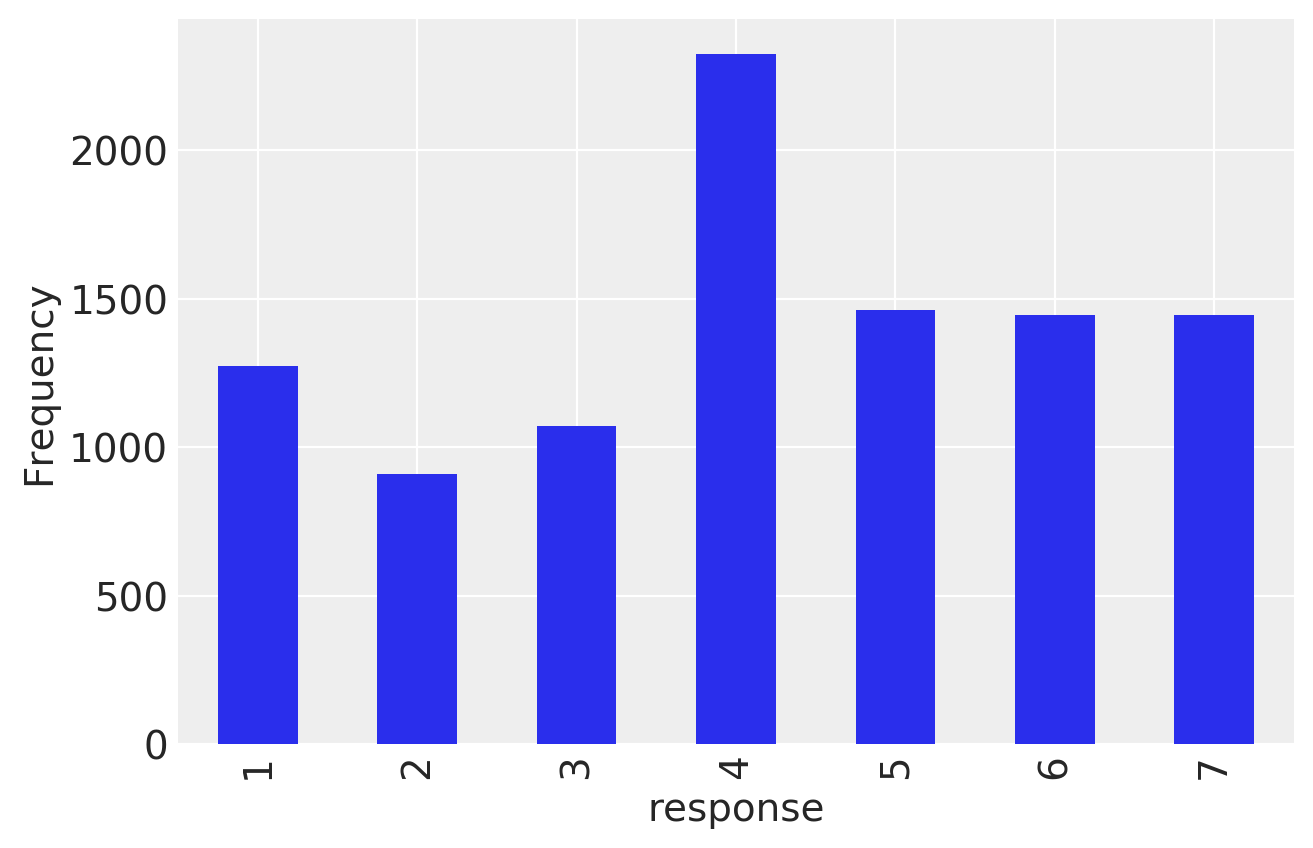

In [4]:
ax = (trolley_df.response
                .value_counts()
                .sort_index()
                .plot(kind='bar'))

ax.set_xlabel("response", fontsize=14);
ax.set_ylabel("Frequency", fontsize=14);

#### Code 11.3

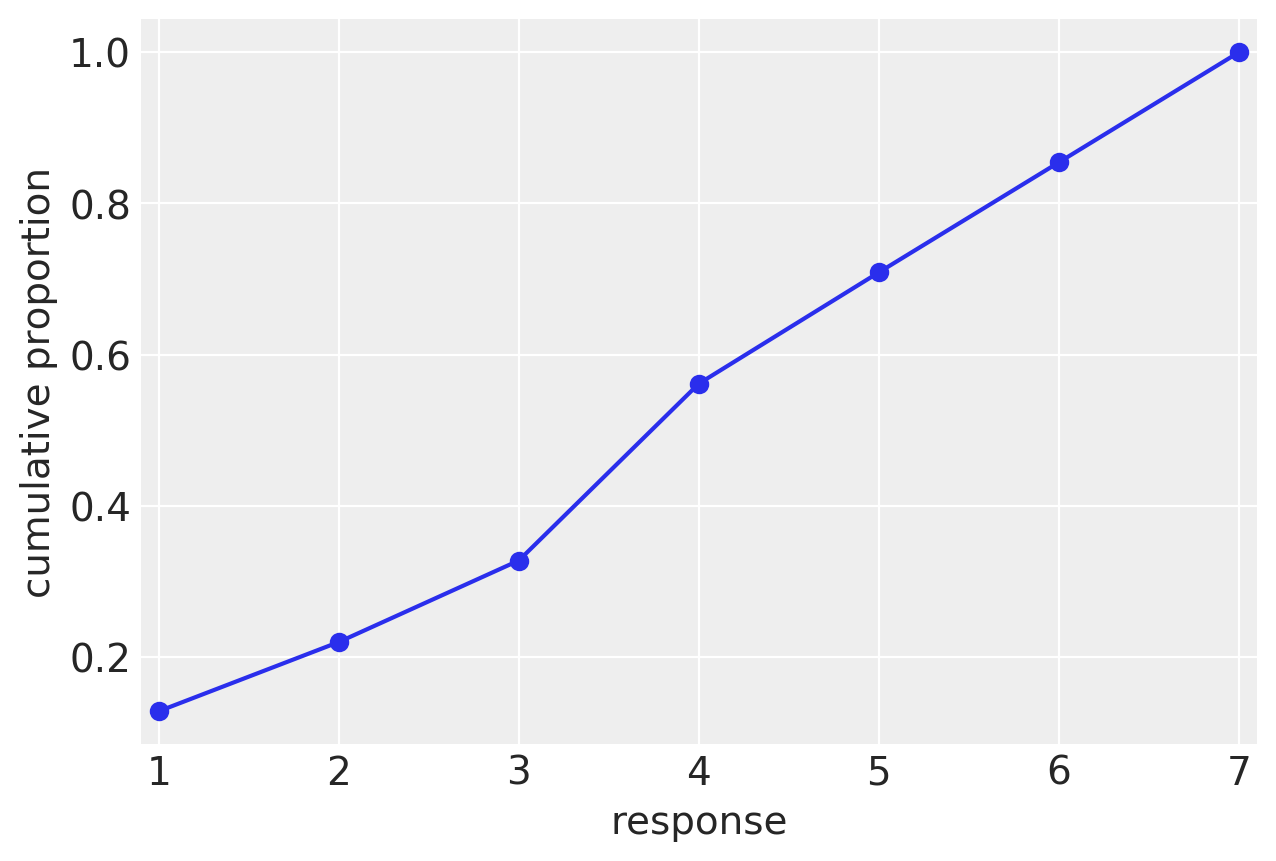

In [5]:
ax = (trolley_df.response
                .value_counts()
                .sort_index()
                .cumsum()
                .div(trolley_df.shape[0])
                .plot(marker='o'))

ax.set_xlim(0.9, 7.1);
ax.set_xlabel("response", fontsize=14)
ax.set_ylabel("cumulative proportion", fontsize=14);

#### Code 11.4

In [6]:
resp_lco = (trolley_df.response
                      .value_counts()
                      .sort_index()
                      .cumsum()
                      .iloc[:-1]
                      .div(trolley_df.shape[0])
                      .apply(lambda p: np.log(p / (1. - p))))

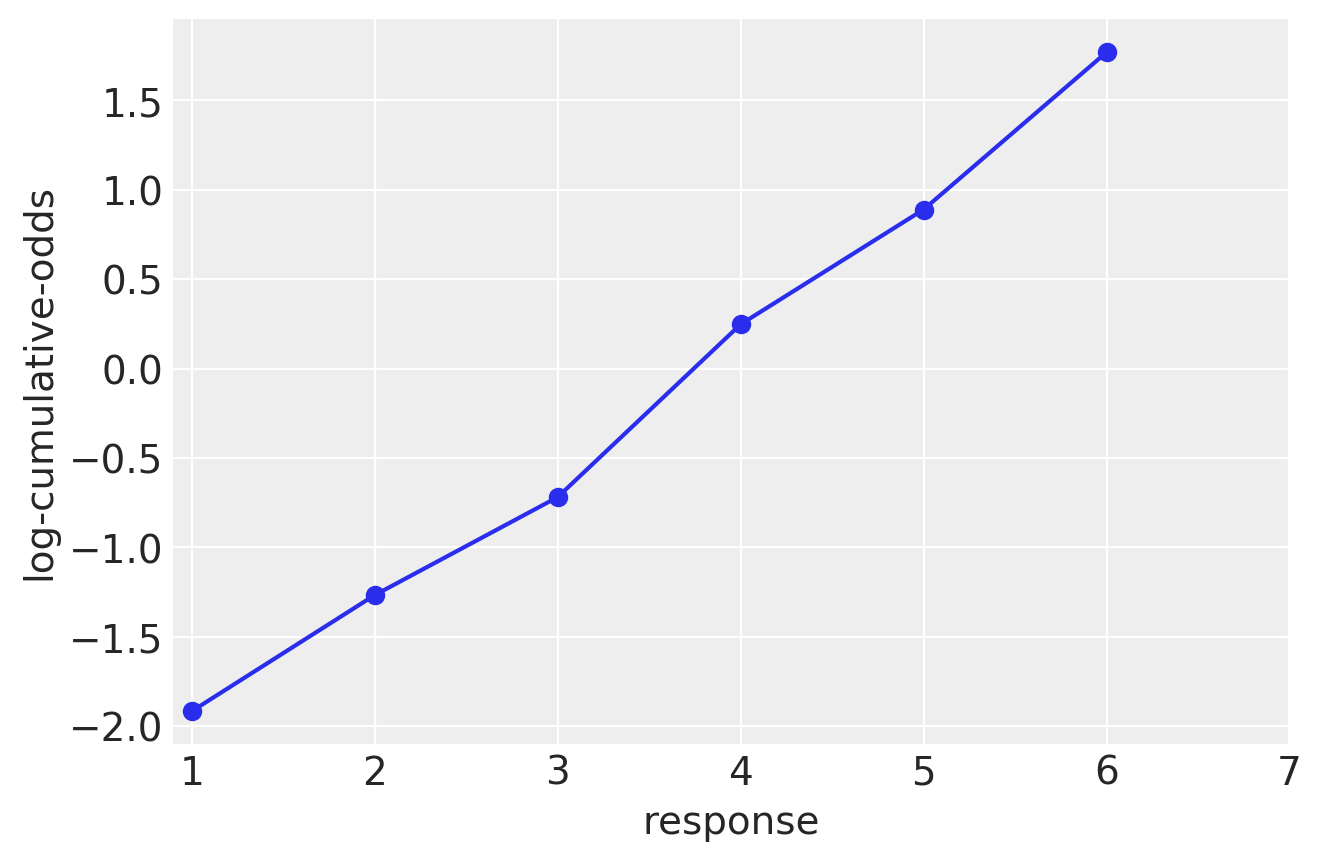

In [7]:
ax = resp_lco.plot(marker='o')

ax.set_xlim(0.9, 7);
ax.set_xlabel("response", fontsize=14)
ax.set_ylabel("log-cumulative-odds", fontsize=14);

#### Code 11.5

In [8]:
with pm.Model() as m11_1:
    a = pm.Normal(
        'a', 0., 10.,
        transform=pm.distributions.transforms.ordered,
        shape=6, testval=np.arange(6) - 2.5)
    
    resp_obs = pm.OrderedLogistic(
        'resp_obs', 0., a,
        observed=trolley_df.response.values - 1
    )

/home/osvaldo/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/osvaldo/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [9]:
with m11_1:
    map_11_1 = pm.find_MAP()

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')


/home/osvaldo/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


#### Code 11.6

In [10]:
map_11_1['a']

array([-1.9160707 , -1.26658298, -0.71862013,  0.24778795,  0.88986631,
        1.76937289])

In [11]:
daf

NameError: name 'daf' is not defined

#### Code 11.7

In [ ]:
sp.special.expit(map_11_1['a'])

#### Code 11.8

In [ ]:
with m11_1:
    trace_11_1 = pm.sample(1000, tune=1000)

In [ ]:
az.summary(trace_11_1, var_names=['a'], credible_interval=.89, rount_to=2)

#### Code 11.9

In [ ]:
def ordered_logistic_proba(a):
    pa = sp.special.expit(a)
    p_cum = np.concatenate(([0.], pa, [1.]))
    
    return p_cum[1:] - p_cum[:-1]

In [ ]:
ordered_logistic_proba(trace_11_1['a'].mean(axis=0))

#### Code 11.10

In [ ]:
(ordered_logistic_proba(trace_11_1['a'].mean(axis=0)) \
     * (1 + np.arange(7))).sum()

#### Code 11.11

In [ ]:
ordered_logistic_proba(trace_11_1['a'].mean(axis=0) - 0.5)

#### Code 11.12

In [ ]:
(ordered_logistic_proba(trace_11_1['a'].mean(axis=0) - 0.5) \
     * (1 + np.arange(7))).sum()

#### Code 11.13

In [ ]:
action = shared(trolley_df.action.values)
intention = shared(trolley_df.intention.values)
contact = shared(trolley_df.contact.values)

with pm.Model() as m11_2:
    a = pm.Normal(
        'a', 0., 10.,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=trace_11_1['a'].mean(axis=0)
    )
    
    bA = pm.Normal('bA', 0., 10.)
    bI = pm.Normal('bI', 0., 10.)
    bC = pm.Normal('bC', 0., 10.)
    phi = bA * action + bI * intention + bC * contact

    resp_obs = pm.OrderedLogistic(
        'resp_obs', phi, a,
        observed=trolley_df.response.values - 1
    )

In [ ]:
with m11_2:
    map_11_2 = pm.find_MAP()

#### Code 11.14

In [ ]:
with pm.Model() as m11_3:
    a = pm.Normal(
        'a', 0., 10.,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=trace_11_1['a'].mean(axis=0)
    )
    
    bA = pm.Normal('bA', 0., 10.)
    bI = pm.Normal('bI', 0., 10.)
    bC = pm.Normal('bC', 0., 10.)
    bAI = pm.Normal('bAI', 0., 10.)
    bCI = pm.Normal('bCI', 0., 10.)
    phi  = bA * action + bI * intention + bC * contact \
            + bAI * action * intention \
            + bCI * contact * intention

    resp_obs = pm.OrderedLogistic(
        'resp_obs', phi, a,
        observed=trolley_df.response - 1
    )

In [ ]:
with m11_3:
    map_11_3 = pm.find_MAP()

#### Code 11.15

In [ ]:
def get_coefs(map_est):
    coefs = OrderedDict()
    
    for i, ai in enumerate(map_est['a']):
        coefs['a_{}'.format(i)] = ai
        
    coefs['bA'] = map_est.get('bA', np.nan)
    coefs['bI'] = map_est.get('bI', np.nan)
    coefs['bC'] = map_est.get('bC', np.nan)
    coefs['bAI'] = map_est.get('bAI', np.nan)
    coefs['bCI'] = map_est.get('bCI', np.nan)
        
    return coefs

In [ ]:
(pd.DataFrame.from_dict(
    OrderedDict([
        ('m11_1', get_coefs(map_11_1)),
        ('m11_2', get_coefs(map_11_2)),
        ('m11_3', get_coefs(map_11_3))
    ]))
   .astype(np.float64)
   .round(2))

#### Code 11.16

In [ ]:
with m11_2:
    trace_11_2 = pm.sample(1000, tune=1000)

In [ ]:
with m11_3:
    trace_11_3 = pm.sample(1000, tune=1000)

In [ ]:
comp_df = pm.compare({m11_1:trace_11_1,
                      m11_2:trace_11_2,
                      m11_3:trace_11_3})

comp_df.loc[:,'model'] = pd.Series(['m11.1', 'm11.2', 'm11.3'])
comp_df = comp_df.set_index('model')
comp_df

#### Code 11.17-19

In [ ]:
pp_df = pd.DataFrame(np.array([[0, 0, 0],
                               [0, 0, 1],
                               [1, 0, 0],
                               [1, 0, 1],
                               [0, 1, 0],
                               [0, 1, 1]]),
                     columns=['action', 'contact', 'intention'])

In [ ]:
pp_df

In [ ]:
action.set_value(pp_df.action.values)
contact.set_value(pp_df.contact.values)
intention.set_value(pp_df.intention.values)

with m11_3:
    pp_trace_11_3 = pm.sample_ppc(trace_11_3, samples=1500)

In [ ]:
PP_COLS = ['pp_{}'.format(i) for i, _ in enumerate(pp_trace_11_3['resp_obs'])]

pp_df = pd.concat((pp_df,
                   pd.DataFrame(pp_trace_11_3['resp_obs'].T, columns=PP_COLS)),
                  axis=1)

In [ ]:
pp_cum_df = (pd.melt(
                    pp_df,
                    id_vars=['action', 'contact', 'intention'],
                    value_vars=PP_COLS, value_name='resp'
                )
               .groupby(['action', 'contact', 'intention', 'resp'])
               .size()
               .div(1500)
               .rename('proba')
               .reset_index()
               .pivot_table(
                   index=['action', 'contact', 'intention'],
                   values='proba',
                   columns='resp'
                )
               .cumsum(axis=1)
               .iloc[:, :-1])

In [ ]:
pp_cum_df

In [ ]:
for (plot_action, plot_contact), plot_df in pp_cum_df.groupby(level=['action', 'contact']):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot([0, 1], plot_df, c='C0');
    ax.plot([0, 1], [0, 0], '--', c='C0');
    ax.plot([0, 1], [1, 1], '--', c='C0');
    
    ax.set_xlim(0, 1);
    ax.set_xlabel("intention");
    
    ax.set_ylim(-0.05, 1.05);
    ax.set_ylabel("probability");
    
    ax.set_title(
        "action = {action}, contact = {contact}".format(
            action=plot_action, contact=plot_contact
        )
    );

#### Code 11.20

In [ ]:
# define parameters
PROB_DRINK = 0.2 # 20% of days
RATE_WORK = 1. # average 1 manuscript per day

# sample one year of production
N = 365

In [ ]:
drink = np.random.binomial(1, PROB_DRINK, size=N)
y = (1 - drink) * np.random.poisson(RATE_WORK, size=N)

#### Code 11.21

In [ ]:
drink_zeros = drink.sum()
work_zeros = (y == 0).sum() - drink_zeros

In [ ]:
bins = np.arange(y.max() + 1) - 0.5

plt.hist(y, bins=bins);
plt.bar(0., drink_zeros, width=1., bottom=work_zeros, color='C1', alpha=.5);

plt.xticks(bins + 0.5);
plt.xlabel("manuscripts completed");

plt.ylabel("Frequency");

#### Code 11.22

In [ ]:
with pm.Model() as m11_4:
    ap = pm.Normal('ap', 0., 1.)
    p = pm.math.sigmoid(ap)
    
    al = pm.Normal('al', 0., 10.)
    lambda_ = pm.math.exp(al)
    
    y_obs = pm.ZeroInflatedPoisson('y_obs', 1. - p, lambda_, observed=y)

In [ ]:
with m11_4:
    map_11_4 = pm.find_MAP()

In [ ]:
map_11_4

#### Code 11.23

In [ ]:
sp.special.expit(map_11_4['ap']) # probability drink

In [ ]:
np.exp(map_11_4['al']) # rate finish manuscripts, when not drinking

#### Code 11.24

In [ ]:
def dzip(x, p, lambda_, log=True):
    like = p**(x == 0) + (1 - p) * sp.stats.poisson.pmf(x, lambda_)
    
    return np.log(like) if log else like

#### Code 11.25

In [ ]:
PBAR = 0.5
THETA = 5.

In [ ]:
a = PBAR * THETA
b = (1 - PBAR) * THETA

In [ ]:
p = np.linspace(0, 1, 100)

plt.plot(p, sp.stats.beta.pdf(p, a, b));

plt.xlim(0, 1);
plt.xlabel("probability");

plt.ylabel("Density");

#### Code 11.26

In [ ]:
admit_df = pd.read_csv('Data/UCBadmit.csv', sep=';')
admit_df.head()

In [ ]:
with pm.Model() as m11_5:
    a = pm.Normal('a', 0., 2.)
    pbar = pm.Deterministic('pbar', pm.math.sigmoid(a))

    theta = pm.Exponential('theta', 1.)
    
    admit_obs = pm.BetaBinomial(
        'admit_obs',
        pbar * theta, (1. - pbar) * theta,
        admit_df.applications.values,
        observed=admit_df.admit.values
    )

In [ ]:
with m11_5:
    trace_11_5 = pm.sample(1000, tune=1000)

#### Code 11.27

In [ ]:
pm.summary(trace_11_5, alpha=.11).round(2)

#### Code 11.28

In [ ]:
np.percentile(trace_11_5['pbar'], [2.5, 50., 97.5])

#### Code 11.29

In [ ]:
pbar_hat = trace_11_5['pbar'].mean()
theta_hat = trace_11_5['theta'].mean()

p_plot = np.linspace(0, 1, 100)

plt.plot(
    p_plot,
    sp.stats.beta.pdf(p_plot, pbar_hat * theta_hat, (1. - pbar_hat) * theta_hat)
);
plt.plot(
    p_plot,
    sp.stats.beta.pdf(
        p_plot[:, np.newaxis],
        trace_11_5['pbar'][:100] * trace_11_5['theta'][:100],
        (1. - trace_11_5['pbar'][:100]) * trace_11_5['theta'][:100]
    ),
    c='C0', alpha=0.1
);

plt.xlim(0., 1.);
plt.xlabel("probability admit");

plt.ylim(0., 3.);
plt.ylabel("Density");

#### Code 11.30

In [ ]:
with m11_5:
    pp_trace_11_5 = pm.sample_ppc(trace_11_5)

In [ ]:
x_case = np.arange(admit_df.shape[0])

plt.scatter(
    x_case,
    pp_trace_11_5['admit_obs'].mean(axis=0) \
        / admit_df.applications.values
);
plt.scatter(x_case, admit_df.admit / admit_df.applications);

high = np.percentile(pp_trace_11_5['admit_obs'], 95, axis=0) \
        / admit_df.applications.values
plt.scatter(x_case, high, marker='x', c='k');

low = np.percentile(pp_trace_11_5['admit_obs'], 5, axis=0) \
        / admit_df.applications.values
plt.scatter(x_case, low, marker='x', c='k');

#### Code 11.31

In [ ]:
mu = 3.
theta = 1.

x = np.linspace(0, 10, 100)
plt.plot(x, sp.stats.gamma.pdf(x, mu / theta, scale=theta));

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))